## Feature engineering

In [50]:
# Load pyspark
import findspark

findspark.init()

#import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F, window

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, Bucketizer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline, Estimator

from multiprocessing.pool import ThreadPool

import datetime
import sys
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données pré-traitées

In [12]:
df_train = spark.read.parquet("data/02-featureEngineering")

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train.printSchema()

df_train = (1456, 29)
root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 |-- station_max_temp_c: float (nullable = true)
 |-- station_min_temp_c: float (nullable = true)
 |-- station_precip_mm: float (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- reanalysis_air_temp_c: double (nullable = true)
 |-- reanalysis_avg_temp_c: double (nullable = true)
 |-- 

In [13]:
# San Juan (sj)
df_train_sj = df_train.filter(df_train.city == 'sj')

# Iquitos (iq)
df_train_iq = df_train.filter(df_train.city == 'iq')

### Décalage

In [14]:
def shift_data(df, shift=0):
    # build a window
    w = window.Window() \
        .partitionBy('city') \
        .orderBy(F.col('week_start_date'))

    # add new columns with different lags
    df = df \
        .withColumn('ndvi_avg',
                    F.lag('ndvi_avg', count=shift).over(w)) \
        .withColumn('reanalysis_precip_amt_kg_per_m2',
                    F.lag('reanalysis_precip_amt_kg_per_m2', count=shift).over(w)) \
        .withColumn('reanalysis_sat_precip_amt_mm',
                    F.lag('reanalysis_sat_precip_amt_mm', count=shift).over(w)) \
        .withColumn('reanalysis_specific_humidity_g_per_kg',
                    F.lag('reanalysis_specific_humidity_g_per_kg', count=shift).over(w)) \
        .withColumn('station_avg_temp_c',
                    F.lag('station_avg_temp_c', count=shift).over(w)) \
        .withColumn('station_diur_temp_rng_c',
                    F.lag('station_diur_temp_rng_c', count=shift).over(w)) \
        .withColumn('station_max_temp_c',
                    F.lag('station_max_temp_c', count=shift).over(w)) \
        .withColumn('station_min_temp_c',
                    F.lag('station_min_temp_c', count=shift).over(w)) \
        .withColumn('station_precip_mm',
                    F.lag('station_precip_mm', count=shift).over(w)) \
        .withColumn('reanalysis_air_temp_c',
                    F.lag('reanalysis_air_temp_c', count=shift).over(w)) \
        .withColumn('reanalysis_avg_temp_c',
                    F.lag('reanalysis_avg_temp_c', count=shift).over(w)) \
        .withColumn('reanalysis_dew_point_temp_c',
                    F.lag('reanalysis_dew_point_temp_c', count=shift).over(w)) \
        .withColumn('reanalysis_max_air_temp_c',
                    F.lag('reanalysis_max_air_temp_c', count=shift).over(w))

    #df = df.dropna()
    
    return df

#v_shift = 0
v_shift = 3

print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))

df_train_sj = shift_data(df_train_sj, shift=v_shift)
df_train_iq = shift_data(df_train_iq, shift=v_shift)
df_train_sj = df_train_sj.dropna()
df_train_iq = df_train_iq.dropna()

print("Applied shift is: {}".format(v_shift))
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))

df_train_sj = (936, 29)
df_train_iq = (520, 29)
Applied shift is: 3
df_train_sj = (933, 29)
df_train_iq = (517, 29)


### Construction des jeux d'entrainement et de test

In [15]:
# split train (90%) and test (10%)

# San Juan (sj)
min_date_sj, max_date_sj = df_train_sj.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

testsize_sj = int(0.1 * df_train_sj.count())
delta_sj = datetime.timedelta(weeks=testsize_sj)
cut_date_sj = max_date_sj - delta_sj

train_sj = df_train_sj.filter(df_train_sj.week_start_date <= cut_date_sj)
test_sj = df_train_sj.filter(df_train_sj.week_start_date > cut_date_sj)

print("train_sj = ({}, {})".format(train_sj.count(), len(train_sj.columns)))
print("test_sj = ({}, {})".format(test_sj.count(), len(test_sj.columns)))

# Iquitos (iq)
min_date_iq, max_date_iq = df_train_iq.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

testsize_iq = int(0.1 * df_train_iq.count())
delta_iq = datetime.timedelta(weeks=testsize_iq)
cut_date_iq = max_date_iq - delta_iq

train_iq = df_train_iq.filter(df_train_iq.week_start_date <= cut_date_iq)
test_iq = df_train_iq.filter(df_train_iq.week_start_date > cut_date_iq)

print("train_iq = ({}, {})".format(train_iq.count(), len(train_iq.columns)))
print("test_iq = ({}, {})".format(test_iq.count(), len(test_iq.columns)))

train_sj = (840, 29)
test_sj = (93, 29)
train_iq = (466, 29)
test_iq = (51, 29)


In [16]:
# concatenate the 2 sets
train = train_sj.union(train_iq)
test = test_sj.union(test_iq)

print("train = ({}, {})".format(train.count(), len(train.columns)))
print("test = ({}, {})".format(test.count(), len(test.columns)))

train = (1306, 29)
test = (144, 29)


### Construction du *pipeline*

In [17]:
# OneHotEncoder categorial variables
indexer = StringIndexer(inputCol='city', outputCol='city_')
encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

# Build feature vector
vectorAssembler = VectorAssembler(
    inputCols=['cityVect',
               'year', 'weekofyear',
##               'bucket_ne', 'bucket_nw', 'bucket_se', 'bucket_sw',
               'ndvi_avg',
               'reanalysis_precip_amt_kg_per_m2',
##               'reanalysis_relative_humidity_percent',
               'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',  
               'reanalysis_air_temp_c',
               'reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c',
               'reanalysis_max_air_temp_c',
##               'reanalysis_min_air_temp_c',
##               'reanalysis_tdtr_c',
               ], 
    outputCol = 'features')

# scaler
scaler = StandardScaler(inputCol='features',
                        outputCol='scaled_features',
                        withStd=True, withMean=True)

# Random forest
rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

### Modèle *Random Forest* (forêt aléatoire)

#### Paramètres par défaut

In [18]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

# build model
model_rf = pipeline_rf.fit(train)

# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

#pred_rf.select(['total_cases','rf_prediction']).show(52)

mae = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - MAE = {:.3f}".format(mae))

Random Forest::Before grid search - MAE = 13.109


#### Ajustement des hyper-paramètres (*grid search*)

#### Custom cross validation

Pour pouvoir utiliser notre propre découpage en folds, nous définissons une classe CustomCrossValidator
(code de https://www.timlrx.com/2018/04/08/creating-a-custom-cross-validation-function-in-pyspark/ très légèrement adapté pour tenir compte des évolutions récentes de Spark)

In [36]:
# cette classe vient de https://www.timlrx.com/2018/04/08/creating-a-custom-cross-validation-function-in-pyspark/

from pyspark.ml.tuning import ValidatorParams, Params, _parallelFitTasks, CrossValidatorModel
from pyspark import keyword_only
from pyspark.ml.param.shared import HasParallelism
from pyspark.ml.param import TypeConverters, Param
from pyspark.ml.util import MLReadable, MLWritable
import threading
import multiprocessing

from multiprocessing.pool import ThreadPool


class CustomCrossValidator(Estimator, ValidatorParams, HasParallelism, MLReadable, MLWritable):
    """
    Modifies CrossValidator allowing custom train and test dataset to be passed into the function
    Bypass generation of train/test via numFolds
    instead train and test set is user defined
    """
    
    splitWord = Param(Params._dummy(), "splitWord", "Tuple to split train and test set e.g. ('train', 'test')",
                      typeConverter=TypeConverters.toListString)
    cvCol = Param(Params._dummy(), "cvCol", "Column name to filter train and test list",
                      typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, estimator=None, estimatorParamMaps=None, evaluator=None,
                 splitWord = ('train', 'test'), cvCol = 'cv', seed=None, parallelism=1):

        super(CustomCrossValidator, self).__init__()
        self._setDefault(parallelism=1)
        kwargs = self._input_kwargs
        self._set(**kwargs)
        
    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)
        eva = self.getOrDefault(self.evaluator)
        nFolds = len(dataset)
        seed = self.getOrDefault(self.seed)
        metrics = [0.0] * numModels
        matrix_metrics = [[0 for x in range(nFolds)] for y in range(len(epm))] 
        
        p= self.getParallelism()
        #p = min(self.getParallelism(), numModels)
        pool = ThreadPool(p)

        for i in range(nFolds):
            validation = dataset[list(dataset.keys())[i]] \
                .filter(F.col(self.getOrDefault(self.cvCol))==(self.getOrDefault(self.splitWord))[0]) \
                .cache()
            train = dataset[list(dataset.keys())[i]] \
                .filter(F.col(self.getOrDefault(self.cvCol))==(self.getOrDefault(self.splitWord))[1]) \
                .cache()
            
            print('fold {}'.format(i))
            #tasks = _parallelFitTasks(est, train, eva, validation, epm)
            tasks = _parallelFitTasks(est, train, eva, validation, epm, False)
            
            print(pool.imap_unordered(lambda f: f(), tasks))
            
            for j, metric in pool.imap_unordered(lambda f: f(), tasks):
                # print(j, metric)
                matrix_metrics[j][i] = metric
                metrics[j] += (metric / nFolds)
            # print(metrics)
            validation.unpersist()
            train.unpersist()

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)
        
        for i in range(len(metrics)):
            print(epm[i], 'Detailed Score {}'.format(matrix_metrics[i]), 'Avg Score {}'.format(metrics[i]))
        
        print('Best Model: ', epm[bestIndex], 'Detailed Score {}'.format(matrix_metrics[bestIndex]),
              'Avg Score {}'.format(metrics[bestIndex]))
        
        ### Do not bother to train on full dataset, just the latest train supplied
        # bestModel = est.fit(dataset, epm[bestIndex])
        bestModel = est.fit(train, epm[bestIndex])
        return self._copyValues(CrossValidatorModel(bestModel, metrics))

Nous découpons nos propres folds :
    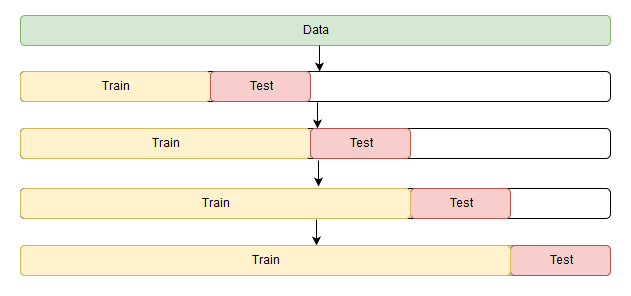
    
Pour San Juan:
date_start = 1990-05-28 / date_stop = 2008-04-22

split San Juan into : 18 years = 6 x 3 years
- train 1990-1993 test 1993-1996
- train 1990-1996 test 1996-1999
- train 1990-1999 test 1999-2002
- train 1990-2002 test 2002-2005
- train 1990-2005 test 2005-2008

In [37]:
from pyspark.sql.functions import lit

def compute_fold(df,cut_date,end_date):
    fold_train = df \
        .filter(df.week_start_date <= cut_date) \
        .withColumn('cv', lit('train'))
    fold_test = df \
        .filter(df.week_start_date > cut_date) \
        .filter(df.week_start_date < end_date) \
        .withColumn('cv', lit('test'))

    print("\tdate_cut = {} / date_stop = {}".format(cut_date, end_date))
    print("fold_train = ({}, {})".format(fold_train.count(), len(fold_train.columns)))
    print("fold_test = ({}, {})".format(fold_test.count(), len(fold_test.columns)))
    return fold_train.union(fold_test)


In [38]:
d = {}

# San Juan data:
# df_train_sj = (932, 52)
# date_start = 1990-05-28 / date_stop = 2008-04-22
# split San Juan into : 18 years = 6 x 3 years

min_date_sj, max_date_sj = train_sj.select(
    F.min("week_start_date"), F.max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

delta = datetime.timedelta(weeks=52*3)
cut_date = min_date_sj + delta
end_date = cut_date + delta
d['fold1'] = compute_fold(train_sj,cut_date,end_date)

cut_date = end_date
end_date = cut_date + delta
d['fold2'] = compute_fold(train_sj,cut_date,end_date)

cut_date = end_date
end_date = cut_date + delta
d['fold3'] = compute_fold(train_sj,cut_date,end_date)

cut_date = end_date
end_date = cut_date + delta
d['fold4'] = compute_fold(train_sj,cut_date,end_date)

cut_date = end_date
end_date = max_date_sj 
d['fold5'] = compute_fold(train_sj,cut_date,end_date)

San Juan data:
df_train_sj = (933, 29)
	date_start = 1990-05-21 / date_stop = 2006-07-09
	date_cut = 1993-05-17 / date_stop = 1996-05-13
fold_train = (156, 30)
fold_test = (155, 30)
	date_cut = 1996-05-13 / date_stop = 1999-05-10
fold_train = (312, 30)
fold_test = (155, 30)
	date_cut = 1999-05-10 / date_stop = 2002-05-06
fold_train = (467, 30)
fold_test = (155, 30)
	date_cut = 2002-05-06 / date_stop = 2005-05-02
fold_train = (622, 30)
fold_test = (156, 30)
	date_cut = 2005-05-02 / date_stop = 2006-07-09
fold_train = (778, 30)
fold_test = (61, 30)


In [39]:
# Parameter grid for random forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 3, 4, 5, 6, 7]) \
    .addGrid(rf.numTrees, [10, 20, 30, 40, 50, 60]) \
    .build()


# Build feature vector
vectorAssembler2 = VectorAssembler(
    inputCols=[
        #'cityVect',
               'year', 'weekofyear',
##               'bucket_ne', 'bucket_nw', 'bucket_se', 'bucket_sw',
               'ndvi_avg',
               'reanalysis_precip_amt_kg_per_m2',
##               'reanalysis_relative_humidity_percent',
               'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',  
               'reanalysis_air_temp_c',
               'reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c',
               'reanalysis_max_air_temp_c',
##               'reanalysis_min_air_temp_c',
##               'reanalysis_tdtr_c',
               ], 
    outputCol = 'features')

#pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler2, scaler, rf])
pipeline_rf = Pipeline(stages=[vectorAssembler2, scaler, rf])



cv = CustomCrossValidator(estimator=pipeline_rf, 
                          estimatorParamMaps=paramGrid_rf, 
                          evaluator=evaluator_rf,
                          splitWord = ('train', 'test'), 
                          cvCol = 'cv', 
                          parallelism = 4,
                          seed=18)



In [40]:
cvModel = cv.fit(d)

fold 0
fold 1
fold 2
fold 3
fold 4
{Param(parent='RandomForestRegressor_b5b0e9493aba', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='RandomForestRegressor_b5b0e9493aba', name='numTrees', doc='Number of trees to train (>= 1).'): 10} Detailed Score [0, 0, 0, 0, 0] Avg Score 0.0
{Param(parent='RandomForestRegressor_b5b0e9493aba', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='RandomForestRegressor_b5b0e9493aba', name='numTrees', doc='Number of trees to train (>= 1).'): 20} Detailed Score [0, 0, 0, 0, 0] Avg Score 0.0
{Param(parent='RandomForestRegressor_b5b0e9493aba', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='RandomForestRegressor_b5b0e9493aba', name='numTrees', do

In [41]:
# Build prediction from 'test' dataset
cv_pred_rf = cvModel.transform(test_sj)

mae = evaluator_rf.evaluate(cv_pred_rf)

print("Random Forest::After grid search custom cross validation San Juan - MAE = {:.3f}".format(mae))

Random Forest::After grid search custom cross validation San Juan - MAE = 18.467


In [43]:
#  Iquitos folds

d_iq = {}

# Iquitos data:
# df_train_iq = (520, 52)
# date_start = 2000-07-01 / date_stop = 2010-06-25
# split Iquitos into : 10 years = 5 x 3 years
# train 2000-2002 test 2002-2004
# train 2000-2004 test 2004-2006
# train 2000-2006 test 2006-2008
# train 2000-2008 test 2008-2010

min_date_iq, max_date_iq = train_iq.select(
    F.min("week_start_date"), F.max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

delta = datetime.timedelta(weeks=52*2)

cut_date = min_date_iq + delta
end_date = cut_date + delta
d_iq['fold1'] = compute_fold(train_iq,cut_date,end_date)

cut_date = end_date
end_date = cut_date + delta
d_iq['fold2'] = compute_fold(train_iq,cut_date,end_date)

cut_date = end_date
end_date = cut_date + delta
d_iq['fold3'] = compute_fold(train_iq,cut_date,end_date)

cut_date = end_date
end_date = max_date_iq
d_iq['fold4'] = compute_fold(train_iq,cut_date,end_date)

Iquitos data:
df_train_iq = (517, 29)
	date_start = 2000-07-22 / date_stop = 2009-07-02
	date_cut = 2002-07-20 / date_stop = 2004-07-17
fold_train = (104, 30)
fold_test = (104, 30)
	date_cut = 2004-07-17 / date_stop = 2006-07-15
fold_train = (208, 30)
fold_test = (103, 30)
	date_cut = 2006-07-15 / date_stop = 2008-07-12
fold_train = (311, 30)
fold_test = (104, 30)
	date_cut = 2008-07-12 / date_stop = 2009-07-02
fold_train = (415, 30)
fold_test = (50, 30)


In [44]:
cvModel_iq = cv.fit(d_iq)

fold 0
fold 1
fold 2
fold 3
{Param(parent='RandomForestRegressor_b5b0e9493aba', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='RandomForestRegressor_b5b0e9493aba', name='numTrees', doc='Number of trees to train (>= 1).'): 10} Detailed Score [0, 0, 0, 0] Avg Score 0.0
{Param(parent='RandomForestRegressor_b5b0e9493aba', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='RandomForestRegressor_b5b0e9493aba', name='numTrees', doc='Number of trees to train (>= 1).'): 20} Detailed Score [0, 0, 0, 0] Avg Score 0.0
{Param(parent='RandomForestRegressor_b5b0e9493aba', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='RandomForestRegressor_b5b0e9493aba', name='numTrees', doc='Number of 

In [45]:
# Build prediction from 'test' dataset
cv_pred_rf_iq = cvModel_iq.transform(test_iq)

mae = evaluator_rf.evaluate(cv_pred_rf_iq)

print("Random Forest::After grid search custom cross validation Iquitos - MAE = {:.3f}".format(mae))

Random Forest::After grid search custom cross validation Iquitos - MAE = 10.230


#### Affichage des predictions obtenues

Nous mesurons la performance du modèle en ragardant les prédictions sur le jeu de données d'entrainement.

In [46]:
pd_train_sj = train_sj.toPandas()
pd_train_iq = train_iq.toPandas()

# create pandas dataframe from spark dataframe

#pd_pred_rf = cv_pred_rf.toPandas()

#pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
#pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

pd_pred_rf_sj = cv_pred_rf.toPandas()
pd_pred_rf_iq = cv_pred_rf_iq.toPandas()

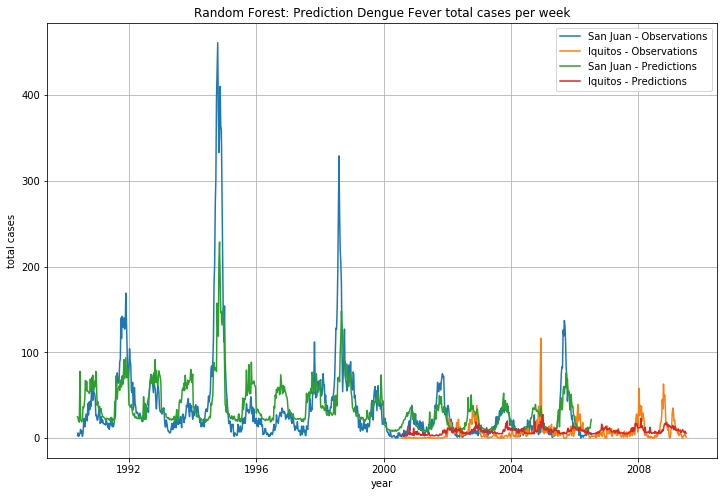

In [47]:
pred_train = rf_bestModel.transform(train)

# create pandas dataframe from spark dataframe
pd_pred_train = pred_train.toPandas()

pd_pred_train_sj = pd_pred_train[pd_pred_train['city'] == 'sj']
pd_pred_train_iq = pd_pred_train[pd_pred_train['city'] == 'iq']

# Total cases per city
fig = plt.figure(figsize=(12, 8))
plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'],
         label='San Juan - Observations')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'],
         label='Iquitos - Observations')

plt.plot(pd_pred_train_sj['week_start_date'], pd_pred_train_sj['rf_prediction'],
         label='San Juan - Predictions')
plt.plot(pd_pred_train_iq['week_start_date'], pd_pred_train_iq['rf_prediction'],
         label='Iquitos - Predictions')

plt.legend()

fig.savefig("figs/05-fig_01.jpg")
plt.show()

## plot LR

### try on test bench

In [48]:
df_bench = spark.read.parquet("data/02-benchmark")

print("df_bench = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

df_bench = shift_data(df_bench,3)

df_bench = (416, 28)


In [51]:
def fill_null_with_next(df_train): 
    # Fill Null value with previous value in the column
    w = window.Window() \
        .partitionBy('city') \
        .orderBy(F.col('week_start_date')) \
        .rowsBetween(0,sys.maxsize)

    for col_name in df_train.columns[4:-1]:
        df_train = df_train.withColumn(col_name, F.first(col_name, True).over(w))
    
    # last column also relevant for the test bench
    df_train = df_train.withColumn(df_train.columns[-1], F.first(df_train.columns[-1], True).over(w))

    return df_train

# replace null value in a column with value of previous cell
df_bench = fill_null_with_next(df_bench)

print("Size of data = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

# identify null value
for col_name in df_bench.columns:
    print("{} => {}".format(col_name,
                            df_bench.filter(F.isnull(df_bench[col_name])).count()))

Size of data = (416, 28)
city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 0
ndvi_nw => 0
ndvi_se => 0
ndvi_sw => 0
reanalysis_precip_amt_kg_per_m2 => 0
reanalysis_relative_humidity_percent => 0
reanalysis_sat_precip_amt_mm => 0
reanalysis_specific_humidity_g_per_kg => 0
station_avg_temp_c => 0
station_diur_temp_rng_c => 0
station_max_temp_c => 0
station_min_temp_c => 0
station_precip_mm => 0
reanalysis_air_temp_c => 0
reanalysis_avg_temp_c => 0
reanalysis_dew_point_temp_c => 0
reanalysis_max_air_temp_c => 0
reanalysis_min_air_temp_c => 0
reanalysis_tdtr_c => 0
bucket_ne => 0
bucket_nw => 0
bucket_sw => 0
bucket_se => 0
ndvi_avg => 0


In [52]:
bench_pred_sj = cvModel.transform(df_bench.filter(df_bench.city == 'sj'))
bench_pred_iq = cvModel_iq.transform(df_bench.filter(df_bench.city == 'iq'))


In [53]:
df_temp_sj = bench_pred_sj['city', 'year', 'weekofyear','rf_prediction'] 
df_temp_sj = df_temp_sj.withColumn("total_cases", df_temp_sj["rf_prediction"].cast('int')) 
df_temp_sj = df_temp_sj.drop('rf_prediction')

df_temp_iq = bench_pred_iq['city', 'year', 'weekofyear','rf_prediction'] 
df_temp_iq =    df_temp_iq.withColumn("total_cases", df_temp_iq["rf_prediction"].cast('int')) 
df_temp_iq =    df_temp_iq.drop('rf_prediction')

In [54]:
df_temp_pandas_sj = df_temp_sj.select('city','year','weekofyear','total_cases').toPandas()
df_temp_pandas_iq = df_temp_iq.select('city','year','weekofyear','total_cases').toPandas()
df_temp_pandas = pd.concat([df_temp_pandas_sj,df_temp_pandas_iq], axis=0)

In [55]:
df_temp_pandas.to_csv('data/custom_cv.csv',index=False)